## Neural network for solving an inital value problem
SA-PINN example

Things to change
- Exact solution: u0 * exp(h*t)
- Compare net against real solution

In [1]:
# import libraries
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
import math

In [2]:
# define functions

In [3]:
# define domain
t_min, t_max = [0, 2]
h_min, h_max = [-1, 1]
t_steps, h_steps = [int(100), int(10)]
u0 = 1

In [4]:
#creates the input vector with the dimensions of (t_steps*h_steps, 2), where t values are in the first and h values in the second column
th_np = np.zeros((t_steps*h_steps,2))
t_np = np.linspace(t_min, t_max, num=t_steps)
h_np = np.linspace(h_min, h_max, num=h_steps)
for i, h in enumerate(h_np):
    th_np[i*t_steps:(i+1)*t_steps,0] = t_np
    th_np[i*t_steps:(i+1)*t_steps,1] = np.full((t_steps), h)
    
#randomize input
from numpy.random import default_rng
rng = default_rng()
th_np_rand = th_np
rng.shuffle(th_np_rand, axis=0)
t_np_rand = th_np_rand[:,0]
h_np_rand = th_np_rand[:,1]

#create tensors from numpy arrays > change here if you want an organized or random input!!!!
t_tensor = torch.tensor(t_np_rand, requires_grad=True).float().view(-1, 1)
h_tensor = torch.tensor(h_np_rand, requires_grad=True).float().view(-1, 1)
print(t_tensor.shape)
print(h_tensor.shape)

torch.Size([1000, 1])
torch.Size([1000, 1])


In [5]:
#define loss functions
# loss_ode: (h*u_net) - u_net'
# loss_ic: u_net(t0) - u0
def loss_ode(net, t, h):
    u = net(t, h)

    #First derivative
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

    F = u*h
    loss_ode = torch.mean((F-u_t)**2)
    
    return loss_ode
def loss_ic(net, t, h):
    #set x[:,0] to 0, leave x[:,1] as it is
    #just substract u0 from it 
    t_0 = torch.ones(t_tensor.shape)
    u_t0 = net(t, h)
    
    loss_ic = torch.mean((u_t0-u0)**2)
    
    return loss_ic

In [6]:
# define network architecture
input_dim = 2
output_dim = 1
gru_out = 256
gru_layers = 1
l1_out = 256
l2_out = 256


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.gru_1 = torch.nn.GRU(input_size=input_dim,
                 hidden_size=gru_out,
                 num_layers=gru_layers, batch_first=True)
        
        self.l1 = torch.nn.Linear(in_features=gru_out,
                            out_features=l1_out,
                            bias=True)
        self.l2 = torch.nn.Linear(in_features=l1_out,
                            out_features=l2_out,
                            bias=True)
        
        # Apply Kaiming initialization to the layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, t, h):
        #x = torch.cat((t, h), 1)
        #hidden state for gru
        #h0 = torch.zeros(gru_layers, x.size(0), gru_out)  # Initial hidden state
        #x, _ = self.gru_1(x, h0)
        #x = nn.Tanh(x),
        #x = self.l1(x)
        #x = nn.Tanh(x),
        #u_out = self.l2(x)
        #return u_out
        x = torch.cat((t, h), 1).unsqueeze(1)  # Add sequence length dimension
        h0 = torch.zeros(gru_layers, x.size(0), gru_out).to(x.device)  # Initial hidden state
        x, _ = self.gru_1(x, h0)  # x is now (batch, seq_len, gru_out)
        x = x.squeeze(1)  # Remove sequence length dimension, now (batch, gru_out)
        x = torch.tanh(x)  # Apply Tanh activation
        x = self.l1(x)  # First Linear layer
        x = torch.tanh(x)  # Apply Tanh activation
        u_out = self.l2(x)  # Second Linear layer
        return u_out
    
net = Net()
    
# hyperparameters
learning_rate = 5e-3
batch_size = 20
num_epochs = 500

#initialize lambdas for soft-adaptation
lambda_ode = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
lambda_ic = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))

#optimizer: weights updates the net, ode and ic update the lambda for soft-adaptation
optimizer_weights = optim.Adam(net.parameters(), lr=learning_rate)
optimizer_ode = optim.Adam([lambda_ode], lr=learning_rate)
optimizer_ic = optim.Adam([lambda_ic], lr=learning_rate)

In [7]:
# train network

#getting epoch sizes
num_samples_train = t_tensor.shape[0]
num_batches_train = num_samples_train // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
#test_acc, test_loss = [], []
cur_loss = 0
losses, ode_losses, ic_losses = [], [], []

get_slice = lambda i, size: range(i * size, (i + 1) * size) #get slices for each batch

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    ode_loss = 0
    ic_loss = 0
    net.train()
    for i in range(num_batches_train):
        # Zero the gradients for all optimizers
        optimizer_weights.zero_grad()
        optimizer_ode.zero_grad()
        optimizer_ic.zero_grad()
        
        slce = get_slice(i, batch_size)
        #x_slice = th_tensor[slce, :]
        output = net(t_tensor[slce, :], h_tensor[slce, :])

        # compute gradients given loss
        batch_loss_ode = loss_ode(net, t_tensor, h_tensor)
        batch_loss_ic = loss_ic(net, t_tensor, h_tensor)
        batch_loss = lambda_ode * batch_loss_ode + lambda_ic * batch_loss_ic # with soft adaptation
        batch_loss.backward()
        #check if pde_loss has gradient
        assert any(param.grad is not None for param in net.parameters()) == True
        
        #maximize gradients of lambdas by inverting the gradient
        with torch.no_grad():
            lambda_ode.grad *= -1
            lambda_ic.grad *= -1
        
        #update net and lambdas
        optimizer_weights.step()
        optimizer_ode.step()
        optimizer_ic.step()

        cur_loss += batch_loss.detach().numpy()
        ode_loss += batch_loss_ode.detach().numpy()
        ic_loss += batch_loss_ic.detach().numpy()
        
    losses.append(cur_loss / batch_size)
    ode_losses.append(ode_loss / batch_size)
    ic_losses.append(ic_loss / batch_size)

    net.eval()

    if epoch % 5 == 0:
        print(
            f"epoch {epoch+1} : Total loss {np.round(losses[-1].item(), decimals=6)} , "
            f"ode loss: {np.round(ode_losses[-1].item(), decimals=6)} , "
            f"pde lambda: {np.round(lambda_ode.item(), decimals=3)} , "
            f"ic loss: {np.round(ic_losses[-1].item(), decimals=6)} , "
            f"ic lambda: {np.round(lambda_ic.item(), decimals=3)}"
    )
        
        
epoch = np.arange(len(losses))
plt.figure()
plt.plot(epoch, losses, 'r')
plt.plot(epoch, ode_losses, 'g')
plt.plot(epoch, ic_losses, 'b')
plt.legend(['Loss', 'ODE loss', 'IC loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')

epoch 1 : Total loss 10.299261 , ode loss: 8.238039 , pde lambda: 1.055 , ic loss: 1.768843 , ic lambda: 1.224
epoch 6 : Total loss 0.001557 , ode loss: 0.000805 , pde lambda: 1.056 , ic loss: 0.00053 , ic lambda: 1.332


KeyboardInterrupt: 

## Visualization

In [8]:
# define analytical solution
def analytical_solution(t, h, u0):
    return u0 * np.exp(h * t)

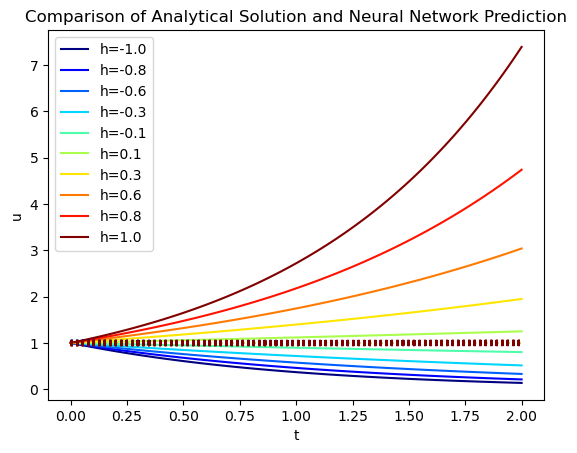

In [9]:
# define domain for plotting the net output
t_values = np.linspace(t_min, t_max, t_steps)
h_values = np.linspace(h_min, h_max, h_steps)

# Convert t_values to a tensor for input to the neural network
t_tensor_plot = torch.tensor(t_values, dtype=torch.float32).view(-1, 1)

# Define a color palette
colors = plt.cm.jet(np.linspace(0, 1, len(h_values)))

# Plot the analytical solutions
for i, h in enumerate(h_values):
    u_analytical = analytical_solution(t_values, h, u0)
    plt.plot(t_values, u_analytical, label=f'h={h:.1f}',color=colors[i])
    # Label the curves
    #plt.text(t_values[-1], u_analytical[-1], f'h={h:.1f}')

# Plot the neural network predictions
for i, h in enumerate(h_values):
    h_tensor_plot = torch.full((t_steps,), h, dtype=torch.float32).view(-1, 1)  # tensor full of h
    u_nn = net(t_tensor_plot, h_tensor_plot).detach().numpy()  # neural network prediction
    plt.plot(t_values, u_nn, color=colors[i], linestyle="dotted")

plt.title('Comparison of Analytical Solution and Neural Network Prediction')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.show()